# RAG APP using Groq API and Langchain

### Imports 

In [20]:
import os 
import getpass
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
import warnings 

warnings.filterwarnings("ignore")

In [7]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Langsmith api key")

### Rag with web loader

load an llm

In [8]:
groq_llm = ChatGroq(
                groq_api_key = os.environ["GROQ_API_KEY"],
                model="llama-3.1-8b-instant",
                temperature = 0.6
                )
#test
groq_llm.invoke("Hello").content

load an embedder 

In [ ]:
embedder = HuggingFaceEmbeddings( 
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
)
#test
embedder.embed_query("Hello")

Vector store 

In [21]:
embedding_dim = len(embedder.embed_query("test"))

In [23]:
index = faiss.IndexFlatL2(embedding_dim)

In [44]:
vectore_store = FAISS(
    embedding_function = embedder,
    index = index,
    docstore = InMemoryDocstore(),
    index_to_docstore_id = {}
)

In [26]:
vectore_store

RAG

In [80]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub
from langchain.prompts import PromptTemplate
from typing_extensions import TypedDict, List
from langgraph.graph import StateGraph, START

In [30]:
#load contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

In [35]:
docs = loader.load()

In [120]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [36]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
docs_splitted = splitter.split_documents(docs)

In [45]:
#Add docs to vectore store
_ = vectore_store.add_documents(documents = docs_splitted)

In [61]:
#prompt template
prompt = """
Answer the following question : {question}
using the relevant informations bellow :
{context}
"""
prompt = PromptTemplate(
    template = prompt,
    input_features = ["question", "context"]
    )

In [65]:
#State of application 
class State(TypedDict):
    question : str
    context : List
    answer : str

In [68]:
#test
context = vectore_store.similarity_search("what is sensory memory ?")

In [73]:
context[0].page_content

962

In [67]:
def retrieve (state : State):
    retrieved_docs = vectore_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [78]:
def generate(state: State):
    context = "\n\n".join([chunk.page_content for chunk in state["context"]])
    messages = prompt.invoke({"question": state["question"], "context": context})
    response = groq_llm.invoke(messages)
    return {"answer": response.content}

In [82]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [84]:
response = graph.invoke({"question": "What is short term memory capacity ?"})

In [86]:
response["answer"]

'Based on the provided information, the short-term memory capacity is believed to be about 7 items. This is a concept introduced by George Miller in 1956, suggesting that the human brain can hold approximately 7 pieces of information in its short-term memory at any given time.'

Display graph

In [89]:
from IPython.display import display, Image

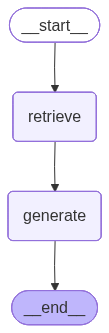

In [91]:
display(Image(graph.get_graph().draw_mermaid_png()))

stream 

In [93]:
for step in graph.stream(
    {"question": "What is short term memory capacity ?"}, 
    stream_mode = "updates"
):
    print (f"{step} \n\n ............ \n")

{'retrieve': {'context': [Document(id='c44f8ed2-0ca1-4e2a-af98-a3d7096350d0', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and needed to carry out complex cognitive tasks such as learning and reasoning. Short-term memory is believed to have the capacity of about 7 items (Miller 1956) and lasts for 20-30 seconds.\n\n\nLong-Term Memory (LTM): Long-term memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. There are two subtypes of LTM:\n\nExplicit / declarative memory: This is memory of facts and events, and refers to those memories that can be consciously recalled, including episodic memory (events and experiences) and semantic memory (facts and concepts).\nImplicit / procedural memory: This type of memory is unconscious and involves skills and routines that are

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is short term memory capacity ?"},
    stream_mode = "messages"
):
    print (message.content, end = '|')

### RAG with local documents 

In [143]:
#Imports 
import faiss
from langchain_groq                         import ChatGroq
from langchain_huggingface                  import HuggingFaceEmbeddings
from langchain.vectorstores                 import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.text_splitter                import RecursiveCharacterTextSplitter
from langchain_core.documents               import Document
from typing_extensions                      import TypedDict, List
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph
import pdfplumber

In [102]:
#LLM
groq_llm = ChatGroq(
    groq_api_key = os.environ["GROQ_API_KEY"],
    model="llama-3.1-8b-instant",
    temperature = 0.5
)

In [104]:
embedder = HuggingFaceEmbeddings(
    model_name ="sentence-transformers/all-MiniLM-L6-v2"
)

In [131]:
#Vector database 
embeddings_ex = embedder.embed_query("hi")
index = faiss.IndexFlatL2(len(embeddings_ex))
vectore_store = FAISS(
    embedding_function = embedder,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [112]:
#fix directory 
os.chdir("..")
print(os.getcwd())

c:\Users\hh\projects\advanced_rag_with_groq_and_langchain


In [113]:
documents = []
with pdfplumber.open("documents/No More Mr. Nice Guy by Robert Glover.pdf") as book:
    for page in book.pages:
        documents.append(page.extract_text())
documents = "\n".join(documents)

In [124]:
documents_structured = Document(page_content=documents)

In [133]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 100)
documents_splitted = splitter.split_documents( [documents_structured])

In [135]:
#Add documents to our vectore store 
_ = vectore_store.add_documents(documents_splitted)

In [136]:
for source in vectore_store.similarity_search(query="How a person can get help from others ?"):
    print (source.page_content)
    print ("---------------")

What kind of helpers do you still need?
l
How can you use these helpers more effectively?
l
How do you prevent these people from helping you?
l
Start looking for opportunities to ask these people for help. Build networks. Before asking for
help, repeat the affirmation: This person wants to help me get my needs met.
Identifying Self-Sabotaging Behaviors Allows Nice Guys To Get the Life They Want
---------------
Breaking Free Activity #43
Do you believe your needs are important? Do you believe other people want to help you meet your
needs?
On a sheet of paper, make a list of helpers you have in your life right now. These can be friends
and family members. They can be professionals such as doctors, lawyers, therapists, and CPAs.
After making the list, answer the following questions:
What kind of helpers do you still need?
l
How can you use these helpers more effectively?
l
---------------
If no one comes to mind, get out the telephone directory and look up counselors or support groups
in 

In [137]:
class State(TypedDict):
    question : str
    context : List
    answer : str

In [142]:
def retrieve(state : State):
    retrieved_docs = vectore_store.similarity_search(state["question"]) 
    return {"context": retrieved_docs}

prompt = """
    Use informations bellow extracted from No more Mr. Nice Guy book written by Robert Glover, to answer the following question : 
    {question}
    If you don't know the answer, don't make up one, simply say I don't know.
    relevant informations : 
    {context}
"""
prompt = PromptTemplate(template = prompt,
               input_variables = ["question", "context"])

def generate(state : State):
    context = "\n\n relevant information :\n".join(text.page_content for text in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": context})
    response = groq_llm.invoke(messages)
    return {"answer": response}

In [144]:
#Compile my graph 
workflow = StateGraph(State).add_sequence([retrieve, generate])
workflow.add_edge(START, "retrieve")
book_rag = workflow.compile()

In [145]:
response = book_rag.invoke({"question": "How a person can get help from others ?"})
response 

{'question': 'How a person can get help from others ?',
 'context': [Document(id='b4a22ac1-b773-45b0-a818-4b34407ce024', metadata={}, page_content='What kind of helpers do you still need?\nl\nHow can you use these helpers more effectively?\nl\nHow do you prevent these people from helping you?\nl\nStart looking for opportunities to ask these people for help. Build networks. Before asking for\nhelp, repeat the affirmation: This person wants to help me get my needs met.\nIdentifying Self-Sabotaging Behaviors Allows Nice Guys To Get the Life They Want'),
  Document(id='72bce605-bbba-4fad-88c1-abd30661616f', metadata={}, page_content='Breaking Free Activity #43\nDo you believe your needs are important? Do you believe other people want to help you meet your\nneeds?\nOn a sheet of paper, make a list of helpers you have in your life right now. These can be friends\nand family members. They can be professionals such as doctors, lawyers, therapists, and CPAs.\nAfter making the list, answer the f

In [148]:
print(response["answer"].content)

Based on the information from the book "No More Mr. Nice Guy" by Robert Glover, here's how a person can get help from others:

To get help from others, you need to:

1. **Identify the helpers you have in your life**: Make a list of friends, family members, professionals, or others who can provide support. You can also look up counselors, support groups, or Employee Assistance Programs if needed.
2. **Identify the helpers you still need**: Reflect on what kind of help you require, such as emotional support, financial assistance, or expertise in a specific area.
3. **Use helpers more effectively**: Build relationships with your helpers, ask for help when needed, and be clear about your needs.
4. **Repeat the affirmation**: Before asking for help, remind yourself that the other person wants to help you meet your needs. This can help you feel more confident and worthy of receiving support.
5. **Start looking for opportunities to ask for help**: Build networks and take initiative to reach o